In [2]:
# %%writefile Ind_Retrace_RIX.py

import os 
import sys 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import QUANTAXIS as QA

import Ind_Model_Base

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
import Analysis_Funs as af

from base.JuUnits import roll_multi_result

%load_ext autoreload
%autoreload 2
%aimport tools.Pretreat_Tools,tools.Sample_Tools,base.JuUnits


class RetraceRate(Ind_Model_Base.Ind_Model):
    optimum_param={'valid':True, 'main':'max_retrace_rate', 'desition_direct':-1, 'window':14, 'freq':'d','neutralize':{'enable':False,'static_mv':False}}
    """回撤（回吐）类指标
        main 默认是回撤率，
        sub（含main）顺序为：回撤率,最大回撤周期,最大回撤,最大下跌恢复周期，最大过山车周期
    """
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'RetraceRate', frequence)
    
    def on_set_params_default(self):
        return {'window':14,'moving':5}
    
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)

    
#     def on_desition_structuring(self, data, ind_data):
#         """
#         """

        
    def kernel(self,dataframe, window=14, moving=5):
        CLOSE = dataframe.close
        if self.ignore_sub_and_desition:
            retraces = CLOSE.rolling(window).apply(lambda x:af.retracing(x)[1])
            return pd.DataFrame({'main':retraces}) 
        else:
            def dealing(arr):
                data_ = arr[:,2]
#                 print(data_)
                retrace = af.retracing(data_)
                climb = af.climbing(data_)
                recover = af.get_longest_recover_duration(data_,af.cross_sign(af.get_direct_sign(data_)))[0]
                rollercoaster = af.get_longest_rollercoaster_duration(data_,af.cross_sign(af.get_direct_sign(data_)))[0]
                
                # 回撤率,最大回撤周期,最大回撤,爬升率,最大爬升周期,最大爬升,恢复，过山车
                return retrace[1],retrace[2],retrace[0],climb[1],climb[2],climb[0],recover,rollercoaster
#             
            res = roll_multi_result(CLOSE, dealing, window, 8)
#             print(res)
#             print(CLOSE.index)
            return pd.DataFrame({'max_retrace_rate':res[:,0], 'max_retrace_duration':res[:,1], 'max_retrace':res[:,2], 
                                 'max_climb_rate':res[:,3], 'max_climb_duration':res[:,4], 'max_climb':res[:,5], 
                                 'recovers_duration':res[:,6], 'rollercoaster_duration':res[:,7]},index=CLOSE.index)
  

    
    def plot(self,):
        pass
#         groups = self.ind_df.groupby(level=1)
#         fig = plt.figure(figsize=(1120/72,210*len(groups)/72))
#         for idx,item in enumerate(groups):
#             inds_ = item[1].reset_index('code',drop=True)
#             ax = fig.add_subplot(len(groups),1,idx+1)
            
            
#             ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知
#             formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
#             index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
# #             d = item[1].reset_index(('date','code'),drop=True)

#             ax.set_title(item[0],color='blue', loc ='left', pad=-10) 
    
#             close = self.data.close.loc[(slice(None),item[0])]
#             close.index = index_
#             close.plot(kind='line', ax=ax)
            
#             ax2 = ax.twinx()
#             ax2.set_ylim([-1,1])
            
#             main = inds_['main']
#             main.index = index_
#             main.plot(kind='line', color='black', ax=ax2,label='stably')
            
#             if not self.ignore_sub_and_desition:
#                 sub = inds_['sub']
#                 sub.index = index_
#                 sub.plot(kind='line', ax=ax2, color='grey',label='unStably')
#                 ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
                
#             plt.legend(loc='lower left', fontsize=10) 
#             plt.xticks(rotation = 0)
    

    

Overwriting Ind_Retrace_RIX.py


最大回撤周期： 14
最大回撤： 24.429290011716947
回撤率： 0.81
最大恢复周期 20 12 32
最大过山车 5 9 14


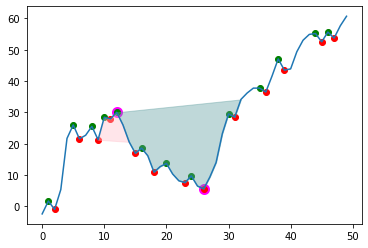

In [1]:


import numpy as np
import matplotlib.pyplot as plt

import Analysis_Funs as af

d = np.random.normal(0,5,50).cumsum()
# d = np.linspace(1,10, num=15)

retrace= af.retracing(d)
print('最大回撤周期：', retrace[2])
print('最大回撤：', retrace[0])
print('回撤率：', retrace[1])
    

xx = af.get_direct_sign(d)
xxcs = af.cross_sign(xx)
# print(xxcs)

recover = af.get_longest_recover_duration(d, xxcs)

print('最大恢复周期', recover[0], recover[1],recover[2])


rollercoaster = af.get_longest_rollercoaster_duration(d, xxcs)

print('最大过山车', rollercoaster[0], rollercoaster[1],rollercoaster[2])
    

plt.plot(range(len(d)),d)
plt.scatter(retrace[3],d[retrace[3]],color='fuchsia',linewidths=5)
plt.scatter(retrace[4],d[retrace[4]],color='fuchsia',linewidths=5)
for idx, cro in enumerate(xxcs):
    if cro == 0:
        continue
    if cro == 1:
        co = 'r'
    else:
        co = 'g'
    plt.scatter(idx,d[idx],color=co,linewidths=1)
    
if rollercoaster[0] != 0:
    plt.fill_between(np.linspace(rollercoaster[1],rollercoaster[2], num=rollercoaster[0]+1), 
                     np.linspace(d[rollercoaster[1]],d[rollercoaster[2]], num=rollercoaster[0]+1), 
                     y2=d[rollercoaster[1]:rollercoaster[2]+1],alpha=0.4,color='pink')

if recover[0] != 0:
    plt.fill_between(np.linspace(recover[1],recover[2], num=recover[0]+1), 
                     np.linspace(d[recover[1]],d[recover[2]], num=recover[0]+1), 
                     y2=d[recover[1]:recover[2]+1],alpha=0.4,color='cadetblue')

plt.show()

# d=[11,12,13,20.,19,18,17,18,23,21]
# np.maximum.accumulate(d)

In [125]:
print(data.close.index.get_level_values(1).unique().to_list())

['600000', '600009', '600016', '600028', '600030', '600031', '600036', '600048', '600050', '600104', '600196', '600276', '600309', '600438', '600519', '600547', '600570', '600585', '600588', '600690', '600703', '600745', '600809', '600837', '600887', '600893', '600918', '601012', '601066', '601088', '601138', '601166', '601211', '601288', '601318', '601336', '601398', '601601', '601628', '601668', '601688', '601818', '601857', '601888', '601899', '601995', '603259', '603288', '603501', '603986']


最大回撤周期： 9
最大回撤： 1.8499999999999979
回撤率： 0.08
[ 0.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.]
[ 0  0 -1  1 -1  0  1  0 -1  1  0 -1  0  0]
最大huifu 2 2 4
最大guoshance 4 9 13


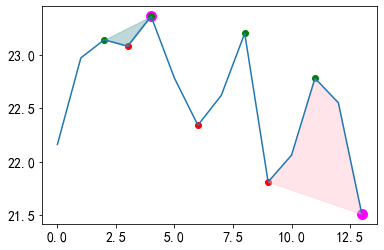

In [37]:
# import tools.Sample_Tools as smpl
# data = smpl.get_sample_by_zs(name='上证50', end='2021-09-03', gap=50, only_main=True)
test = data.close.loc[:,'000001'][0+10:14+10]

test_retrace= af.retracing(test)
print('最大回撤周期：', test_retrace[2])
print('最大回撤：', test_retrace[0])
print('回撤率：', test_retrace[1])

# print(test)
test_direct = af.get_direct_sign(test)
print(test_direct)
test_cs = af.cross_sign(test_direct)
print(test_cs)
test_re = af.get_longest_recover_duration(test.values, test_cs)
test_rc = af.get_longest_rollercoaster_duration(test.values, test_cs)

print('最大huifu', test_re[0], test_re[1],test_re[2])
print('最大guoshance', test_rc[0], test_rc[1],test_rc[2])

plt.plot(range(len(test)),test)
plt.scatter(test_retrace[3],test[test_retrace[3]],color='fuchsia',linewidths=5)
plt.scatter(test_retrace[4],test[test_retrace[4]],color='fuchsia',linewidths=5)

for idx, cro in enumerate(test_cs):
    if cro == 0:
        continue
    if cro == 1:
        co = 'r'
    else:
        co = 'g'
    plt.scatter(idx,test[idx],color=co,linewidths=1)
    
if test_rc[0] != 0:
    plt.fill_between(np.linspace(test_rc[1],test_rc[2], num=test_rc[0]+1), 
                     np.linspace(test[test_rc[1]],test[test_rc[2]], num=test_rc[0]+1), 
                     y2=test[test_rc[1]:test_rc[2]+1],alpha=0.4,color='pink')

if test_re[0] != 0:
    plt.fill_between(np.linspace(test_re[1],test_re[2], num=test_re[0]+1), 
                     np.linspace(test[test_re[1]],test[test_re[2]], num=test_re[0]+1), 
                     y2=test[test_re[1]:test_re[2]+1],alpha=0.4,color='cadetblue')

plt.show()

In [56]:
# data = smpl.get_sample_by_zs(name='上证50', end='2021-09-03', gap=252, only_main=True)
data = smpl.get_data(['000001','000002','000004','000005','000006'], end='2021-09-03', gap=64)
# df_re = smpl.resample_stockdata_low(data.data,'M')
p = RetraceRate(data)
p.change_pramas(window=14)
p.set_ignore_sub_ind(False)
p.fit()

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', 999):
    print(p.ind_df.loc[(slice(None),'000001'),:])

                   max_retrace_rate  max_retrace_duration  max_retrace  max_climb_rate  max_climb_duration  max_climb  recovers_duration  rollercoaster_duration
date       code                                                                                                                                                 
2021-06-04 000001               NaN                   NaN          NaN             NaN                 NaN        NaN                NaN                     NaN
2021-06-07 000001               NaN                   NaN          NaN             NaN                 NaN        NaN                NaN                     NaN
2021-06-08 000001               NaN                   NaN          NaN             NaN                 NaN        NaN                NaN                     NaN
2021-06-09 000001               NaN                   NaN          NaN             NaN                 NaN        NaN                NaN                     NaN
2021-06-10 000001               Na

In [12]:
from numpy.lib.stride_tricks import as_strided as stride
# import pandas as pd

dates = pd.date_range('20130101', periods=13, freq='D')
dfx = pd.DataFrame({'C': [1.6, 4.1, 2.7, 4.9, 5.4, 1.3, 6.6, 9.6, 3.5, 5.4, 10.1, 3.08, 5.38],'D': [2, 3, 4, 5, 6, 1.3, 6.6, 9.6, 3.5, 5.4, 10.1, 3.08, 5.38]}, index=dates)
dfx.index.name = 'datetime'

dfs = dfx['C']

def own_func_np2(arr, **kwargs):
    c = arr[:, 1]
#     d = arr[:, 2]
    return np.mean(c), np.max(c) #+ np.min(d)

result = roll_multi_result(dfs, own_func_np2, 3, 2)
dfx['a']= result[:,0]
dfx['b']= result[:,1]

In [28]:
def tttt(arr):
    close = arr[:,2]
    print(close)
    return close.mean(),close.max()

def roll(df: pd.DataFrame, apply_func: callable, window: int, return_col_num: int, **kwargs):
    # move index to values
    v = df.reset_index().values

    dim0, dim1 = v.shape
    stride0, stride1 = v.strides

    stride_values = stride(v, (dim0 - (window - 1), window, dim1), (stride0, stride0, stride1))

    result_values = np.full((dim0, return_col_num), np.nan)

    for idx, values in enumerate(stride_values, window - 1):
        # values : col 1 is index, other is value
        result_values[idx,] = apply_func(values, **kwargs)

    return result_values

# data.close.reset_index(drop=True).reset_index().values.shape
# res = roll(data.close, tttt, 5, 2)
# data.close.reset_index().values
# res
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', 999):
    print(data.close.loc[:,'000001'])

date
2021-06-04    24.54
2021-06-07    24.30
2021-06-08    24.53
2021-06-09    24.65
2021-06-10    24.20
2021-06-11    23.37
2021-06-15    23.22
2021-06-16    23.26
2021-06-17    23.10
2021-06-18    22.65
2021-06-21    22.16
2021-06-22    22.97
2021-06-23    23.14
2021-06-24    23.08
2021-06-25    23.36
2021-06-28    22.78
2021-06-29    22.34
2021-06-30    22.62
2021-07-01    23.20
2021-07-02    21.81
2021-07-05    22.06
2021-07-06    22.78
2021-07-07    22.55
2021-07-08    21.51
2021-07-09    21.27
2021-07-12    21.16
2021-07-13    21.12
2021-07-14    20.76
2021-07-15    21.62
2021-07-16    21.34
2021-07-19    21.21
2021-07-20    20.60
2021-07-21    20.45
2021-07-22    20.38
2021-07-23    20.10
2021-07-26    18.80
2021-07-27    17.76
2021-07-28    17.75
2021-07-29    17.96
2021-07-30    17.69
2021-08-02    18.01
2021-08-03    17.89
2021-08-04    17.81
2021-08-05    17.68
2021-08-06    17.86
2021-08-09    19.06
2021-08-10    19.73
2021-08-11    19.81
2021-08-12    19.89
2021-08-13    1

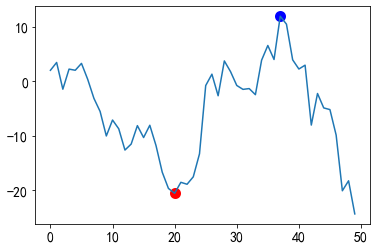

In [3]:
def climbup(data:np.ndarray):
    '''上升
       :param data: ;
       :return：{tuple} -- tuple(最大上升,上升率,最大上升周期,底下标,顶下标)
    '''
    top_index = np.argmax(data-np.minimum.accumulate(data))
    if top_index == 0:
        return 0, 0, 0, 0, 0
    bottom_index = np.argmin(data[:top_index])
    
    duration = bottom_index - top_index
    up = data[top_index] - data[bottom_index]
    up_rate = np.round(up / data[bottom_index], 2)
    return up, up_rate, duration, bottom_index, top_index

d = np.random.normal(0,5,50).cumsum()
# d = np.linspace(1,10, num=15)


climb = climbup(d)
plt.plot(range(len(d)),d)
plt.scatter(climb[3],d[climb[3]],color='r',linewidths=5)
plt.scatter(climb[4],d[climb[4]],color='b',linewidths=5)
plt.show()